## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [35]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [36]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [37]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [38]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [39]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: 7')

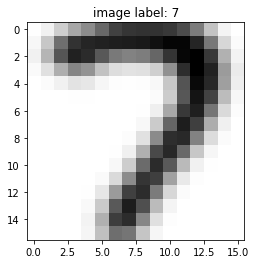

In [40]:
sample_index = 90
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

In [41]:
img, label = dataset[90]
print(img.shape)
print(label)

torch.Size([1, 16, 16])
7


In [42]:
img.unsqueeze(0).shape

torch.Size([1, 1, 16, 16])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

In [43]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h = F.relu(self.l1(inputs))
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

## Train your Model

In [44]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [45]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    plt.plot(range(1, num_epochs+1), train_error)
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")
    return train_error

Epoch [1/10], Loss: 0.0850
Epoch [2/10], Loss: 0.0707
Epoch [3/10], Loss: 0.0576
Epoch [4/10], Loss: 0.0451
Epoch [5/10], Loss: 0.0345
Epoch [6/10], Loss: 0.0265
Epoch [7/10], Loss: 0.0211
Epoch [8/10], Loss: 0.0177
Epoch [9/10], Loss: 0.0156
Epoch [10/10], Loss: 0.0140


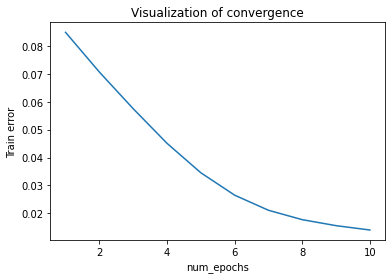

In [46]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

### Evaluate the Model on validation set

In [48]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))
    return format(100*correct.item()/ len(dataset))

In [49]:
accuracy(val_set, model)

Accuracy of the model : 91.71 %


'91.71185127807901'

Text(0.5, 1.0, 'Prediction label: 0')

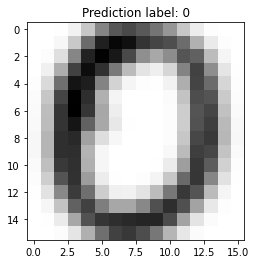

In [50]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [51]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.c1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
        self.r1 = nn.ReLU()
        self.p1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.c2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.r2 = nn.ReLU()
        self.p2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.c3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.r3 = nn.ReLU()
        self.p3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(64*2*2, 10)

    def forward(self, inputs):
        x = self.p1(self.r1(self.c1(inputs)))
        x = self.p2(self.r2(self.c2(x)))
        x = self.p3(self.r3(self.c3(x)))
        #flatten the output of conv2d to linear :(batch_size, 32 * 4 * 4)
        # x = x.view(-1, 720)
        x = x.view(x.size(0), -1)
        output = F.softmax(self.fc1(x), dim=1)# Use softmax as the activation function for the last layer
        # output = self.fc1(x)
        return output

In [52]:
# define a function for training
def train_conv(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images) #reshape the inputs from [N, img_shape, img_shape] to [N, C, img_shape, img_shape] mandatory for convolution 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    
    plt.plot(range(1, num_epochs+1), train_error)
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")
    return train_error

Epoch [1/10], Loss: 0.0886
Epoch [2/10], Loss: 0.0517
Epoch [3/10], Loss: 0.0170
Epoch [4/10], Loss: 0.0106
Epoch [5/10], Loss: 0.0084
Epoch [6/10], Loss: 0.0068
Epoch [7/10], Loss: 0.0062
Epoch [8/10], Loss: 0.0051
Epoch [9/10], Loss: 0.0047
Epoch [10/10], Loss: 0.0046


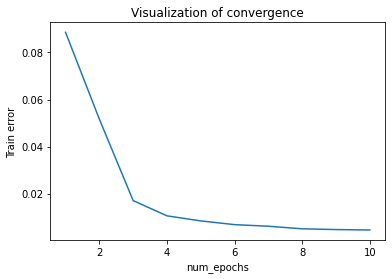

In [53]:
# Create the model: 
model = ConvNet()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 3

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error_conv = train_conv(num_epochs, batch_size, criterion, optimizer, model, train_set)

In [54]:
# Calculate the accuracy to evaluate the model
def accuracy_conv(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))
    return format(100*correct.item()/ len(dataset))

In [55]:
accuracy_conv(val_set, model)

Accuracy of the model : 96.75 %


'96.74670797831139'

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

##### Try different batch_size

Epoch [1/10], Loss: 0.0825
Epoch [2/10], Loss: 0.0248
Epoch [3/10], Loss: 0.0104
Epoch [4/10], Loss: 0.0075
Epoch [5/10], Loss: 0.0060
Epoch [6/10], Loss: 0.0047
Epoch [7/10], Loss: 0.0045
Epoch [8/10], Loss: 0.0037
Epoch [9/10], Loss: 0.0031
Epoch [10/10], Loss: 0.0029
Accuracy of the model : 98.22 %
Epoch [1/10], Loss: 0.0880
Epoch [2/10], Loss: 0.0523
Epoch [3/10], Loss: 0.0179
Epoch [4/10], Loss: 0.0113
Epoch [5/10], Loss: 0.0092
Epoch [6/10], Loss: 0.0079
Epoch [7/10], Loss: 0.0068
Epoch [8/10], Loss: 0.0061
Epoch [9/10], Loss: 0.0053
Epoch [10/10], Loss: 0.0047
Accuracy of the model : 96.20 %
Epoch [1/10], Loss: 0.0897
Epoch [2/10], Loss: 0.0885
Epoch [3/10], Loss: 0.0806
Epoch [4/10], Loss: 0.0536
Epoch [5/10], Loss: 0.0258
Epoch [6/10], Loss: 0.0169
Epoch [7/10], Loss: 0.0131
Epoch [8/10], Loss: 0.0107
Epoch [9/10], Loss: 0.0092
Epoch [10/10], Loss: 0.0081
Accuracy of the model : 95.43 %
Epoch [1/10], Loss: 0.0894
Epoch [2/10], Loss: 0.0876
Epoch [3/10], Loss: 0.0780
Epoch [4/1

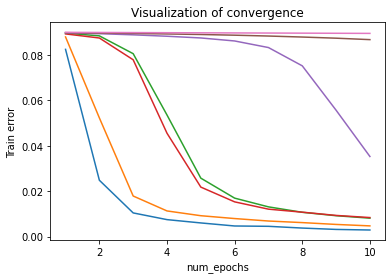

In [56]:
# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = [2, 4, 8, 10, 20, 50, 100]

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#empty list to record the accuracy
accuracy_per_batchsize = []

for nbr_batchsize in batch_size:

    #reset model
    model = ConvNet()
    # reset optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    train_error_conv = train_conv(num_epochs, nbr_batchsize, criterion, optimizer, model, train_set)
    accuracy_per_batchsize.append(float(accuracy_conv(val_set, model)))

In [57]:
accuracy_per_batchsize

[98.21843532145624,
 96.20449264136329,
 95.42989930286599,
 95.12006196746708,
 85.20526723470178,
 16.65375677769171,
 16.65375677769171]

Text(0.5, 1.0, 'Accuracy per batchsize')

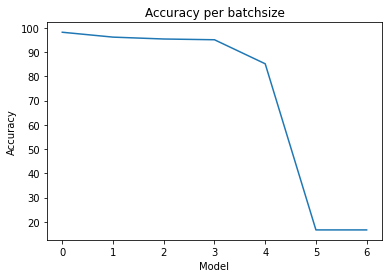

In [58]:
#plot accuracy
plt.plot(accuracy_per_batchsize)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy per batchsize")

##### Try different learning rate

##### Convolutional NN

Epoch [1/10], Loss: 0.0901
Epoch [2/10], Loss: 0.0900
Epoch [3/10], Loss: 0.0899
Epoch [4/10], Loss: 0.0898
Epoch [5/10], Loss: 0.0897
Epoch [6/10], Loss: 0.0896
Epoch [7/10], Loss: 0.0895
Epoch [8/10], Loss: 0.0894
Epoch [9/10], Loss: 0.0893
Epoch [10/10], Loss: 0.0891
Accuracy of the model : 16.65 %
Epoch [1/10], Loss: 0.0894
Epoch [2/10], Loss: 0.0876
Epoch [3/10], Loss: 0.0772
Epoch [4/10], Loss: 0.0472
Epoch [5/10], Loss: 0.0235
Epoch [6/10], Loss: 0.0154
Epoch [7/10], Loss: 0.0124
Epoch [8/10], Loss: 0.0107
Epoch [9/10], Loss: 0.0096
Epoch [10/10], Loss: 0.0087
Accuracy of the model : 94.27 %
Epoch [1/10], Loss: 0.0501
Epoch [2/10], Loss: 0.0104
Epoch [3/10], Loss: 0.0066
Epoch [4/10], Loss: 0.0050
Epoch [5/10], Loss: 0.0042
Epoch [6/10], Loss: 0.0033
Epoch [7/10], Loss: 0.0028
Epoch [8/10], Loss: 0.0025
Epoch [9/10], Loss: 0.0021
Epoch [10/10], Loss: 0.0019
Accuracy of the model : 96.75 %
Epoch [1/10], Loss: 0.1260
Epoch [2/10], Loss: 0.1815
Epoch [3/10], Loss: 0.1715
Epoch [4/1

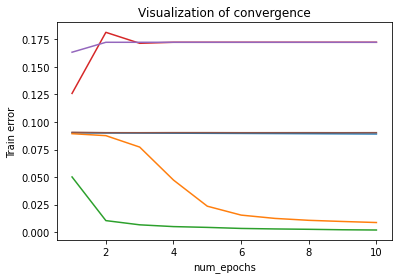

In [59]:
# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 1

# Use mean squared loss function 
criterion = nn.MSELoss()

#different learning rate
lr = [0.001, 0.01, 0.1, 1, 5, 10]

#empty list to record the accuracy
accuracy_per_lr_CNN = []

for nbr_lr in lr:

    #reset model
    model = ConvNet()
    # reset optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=nbr_lr)

    train_error_conv = train_conv(num_epochs, batch_size, criterion, optimizer, model, train_set)
    accuracy_per_lr_CNN.append(float(accuracy_conv(val_set, model)))

In [60]:
accuracy_per_lr_CNN

[16.65375677769171,
 94.26800929512007,
 96.74670797831139,
 13.787761425251743,
 13.787761425251743,
 13.787761425251743]

Text(0.5, 1.0, 'Accuracy per lr (CNN)')

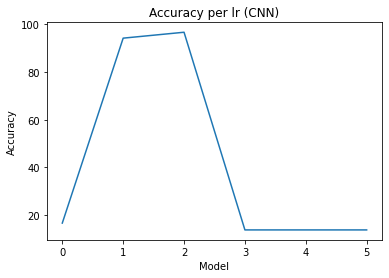

In [61]:
#plot accuracy
plt.plot(accuracy_per_lr_CNN)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy per lr (CNN)")

##### Linear NN

Epoch [1/10], Loss: 0.0900
Epoch [2/10], Loss: 0.0892
Epoch [3/10], Loss: 0.0884
Epoch [4/10], Loss: 0.0873
Epoch [5/10], Loss: 0.0860
Epoch [6/10], Loss: 0.0845
Epoch [7/10], Loss: 0.0832
Epoch [8/10], Loss: 0.0819
Epoch [9/10], Loss: 0.0808
Epoch [10/10], Loss: 0.0797
Accuracy of the model : 35.40 %
Epoch [1/10], Loss: 0.0862
Epoch [2/10], Loss: 0.0742
Epoch [3/10], Loss: 0.0618
Epoch [4/10], Loss: 0.0485
Epoch [5/10], Loss: 0.0362
Epoch [6/10], Loss: 0.0277
Epoch [7/10], Loss: 0.0217
Epoch [8/10], Loss: 0.0180
Epoch [9/10], Loss: 0.0157
Epoch [10/10], Loss: 0.0141
Accuracy of the model : 91.48 %
Epoch [1/10], Loss: 0.0417
Epoch [2/10], Loss: 0.0118
Epoch [3/10], Loss: 0.0090
Epoch [4/10], Loss: 0.0077
Epoch [5/10], Loss: 0.0072
Epoch [6/10], Loss: 0.0065
Epoch [7/10], Loss: 0.0061
Epoch [8/10], Loss: 0.0056
Epoch [9/10], Loss: 0.0053
Epoch [10/10], Loss: 0.0052
Accuracy of the model : 95.12 %
Epoch [1/10], Loss: 0.0234
Epoch [2/10], Loss: 0.0157
Epoch [3/10], Loss: 0.0162
Epoch [4/1

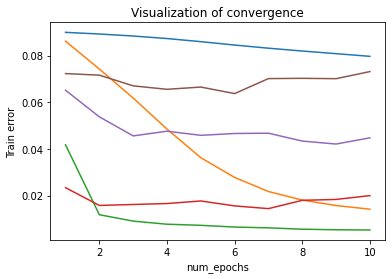

In [62]:
# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 1

# Use mean squared loss function 
criterion = nn.MSELoss()

#different learning rate
lr = [0.001, 0.01, 0.1, 1, 5, 10]

#empty list to record the accuracy
accuracy_per_lr_LNN = []

for nbr_lr in lr:

    #reset model
    model = Model()
    # reset optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=nbr_lr)

    train_error_conv = train(num_epochs, batch_size, criterion, optimizer, model, train_set)
    accuracy_per_lr_LNN.append(float(accuracy(val_set, model)))

In [63]:
accuracy_per_lr_LNN

[35.39891556932611,
 91.47947327652982,
 95.12006196746708,
 91.4020139426801,
 59.798605731990705,
 38.03253292021689]

Text(0.5, 1.0, 'Accuracy per lr (LNN)')

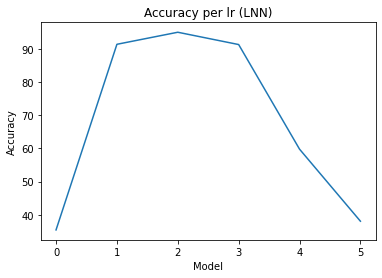

In [64]:
#plot accuracy

plt.plot(accuracy_per_lr_LNN)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy per lr (LNN)")

##### Try different epochs

Epoch [1/5], Loss: 0.0498
Epoch [2/5], Loss: 0.0101
Epoch [3/5], Loss: 0.0070
Epoch [4/5], Loss: 0.0052
Epoch [5/5], Loss: 0.0044
Accuracy of the model : 97.13 %
Epoch [1/10], Loss: 0.0472
Epoch [2/10], Loss: 0.0105
Epoch [3/10], Loss: 0.0075
Epoch [4/10], Loss: 0.0054
Epoch [5/10], Loss: 0.0043
Epoch [6/10], Loss: 0.0036
Epoch [7/10], Loss: 0.0032
Epoch [8/10], Loss: 0.0026
Epoch [9/10], Loss: 0.0021
Epoch [10/10], Loss: 0.0018
Accuracy of the model : 97.68 %
Epoch [1/15], Loss: 0.0512
Epoch [2/15], Loss: 0.0106
Epoch [3/15], Loss: 0.0075
Epoch [4/15], Loss: 0.0054
Epoch [5/15], Loss: 0.0043
Epoch [6/15], Loss: 0.0038
Epoch [7/15], Loss: 0.0026
Epoch [8/15], Loss: 0.0026
Epoch [9/15], Loss: 0.0020
Epoch [10/15], Loss: 0.0017
Epoch [11/15], Loss: 0.0014
Epoch [12/15], Loss: 0.0018
Epoch [13/15], Loss: 0.0014
Epoch [14/15], Loss: 0.0011
Epoch [15/15], Loss: 0.0008
Accuracy of the model : 98.22 %
Epoch [1/20], Loss: 0.0508
Epoch [2/20], Loss: 0.0098
Epoch [3/20], Loss: 0.0064
Epoch [4/20

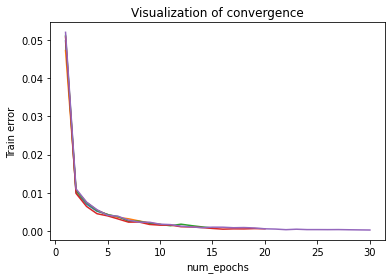

In [65]:
# Choose the hyperparameters for training:
# try different epochs 
num_epochs = [5, 10, 15, 20, 30]
batch_size = 1

# Use mean squared loss function 
criterion = nn.MSELoss()

#empty list to record the accuracy
accuracy_per_epochs = []

for nbr_epochs in num_epochs:

    #reset model
    model = ConvNet()
    # reset optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    train_error_conv = train_conv(nbr_epochs, batch_size, criterion, optimizer, model, train_set)
    accuracy_per_epochs.append(float(accuracy_conv(val_set, model)))

In [66]:
accuracy_per_epochs

[97.13400464756003,
 97.67621998450814,
 98.21843532145624,
 98.68319132455461,
 98.45081332300542]

Text(0.5, 1.0, 'Accuracy per number of epochs')

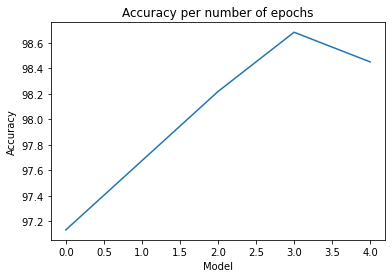

In [67]:
#plot accuracy

plt.plot(accuracy_per_epochs)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy per number of epochs")

##### Try different optimizers

Epoch [1/20], Loss: 0.0892
Epoch [2/20], Loss: 0.0858
Epoch [3/20], Loss: 0.0616
Epoch [4/20], Loss: 0.0276
Epoch [5/20], Loss: 0.0161
Epoch [6/20], Loss: 0.0119
Epoch [7/20], Loss: 0.0100
Epoch [8/20], Loss: 0.0087
Epoch [9/20], Loss: 0.0076
Epoch [10/20], Loss: 0.0072
Epoch [11/20], Loss: 0.0063
Epoch [12/20], Loss: 0.0057
Epoch [13/20], Loss: 0.0054
Epoch [14/20], Loss: 0.0052
Epoch [15/20], Loss: 0.0049
Epoch [16/20], Loss: 0.0044
Epoch [17/20], Loss: 0.0042
Epoch [18/20], Loss: 0.0040
Epoch [19/20], Loss: 0.0036
Epoch [20/20], Loss: 0.0036
Accuracy of the model : 97.29 %


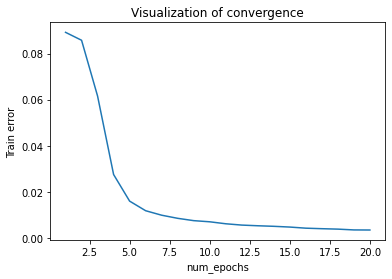

In [68]:
# Choose the hyperparameters for training:
# try different epochs 
num_epochs = 20
batch_size = 8

# Use mean squared loss function 
criterion = nn.MSELoss()


#new model
model = ConvNet()


#Classic SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#empty list to record the accuracy
accuracy_per_opti = []


train_error_conv = train_conv(num_epochs, batch_size, criterion, optimizer, model, train_set)
accuracy_per_opti.append(float(accuracy_conv(val_set, model)))

Epoch [1/20], Loss: 0.0240
Epoch [2/20], Loss: 0.0075
Epoch [3/20], Loss: 0.0055
Epoch [4/20], Loss: 0.0042
Epoch [5/20], Loss: 0.0036
Epoch [6/20], Loss: 0.0029
Epoch [7/20], Loss: 0.0027
Epoch [8/20], Loss: 0.0022
Epoch [9/20], Loss: 0.0023
Epoch [10/20], Loss: 0.0017
Epoch [11/20], Loss: 0.0015
Epoch [12/20], Loss: 0.0012
Epoch [13/20], Loss: 0.0011
Epoch [14/20], Loss: 0.0015
Epoch [15/20], Loss: 0.0010
Epoch [16/20], Loss: 0.0008
Epoch [17/20], Loss: 0.0011
Epoch [18/20], Loss: 0.0010
Epoch [19/20], Loss: 0.0007
Epoch [20/20], Loss: 0.0009
Accuracy of the model : 98.84 %


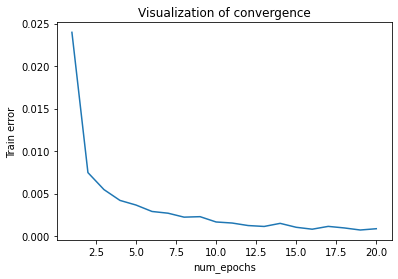

In [69]:
#new model
model = ConvNet()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_error_conv = train_conv(num_epochs, batch_size, criterion, optimizer, model, train_set)
accuracy_per_opti.append(float(accuracy_conv(val_set, model)))

Epoch [1/20], Loss: 0.0183
Epoch [2/20], Loss: 0.0072
Epoch [3/20], Loss: 0.0056
Epoch [4/20], Loss: 0.0041
Epoch [5/20], Loss: 0.0033
Epoch [6/20], Loss: 0.0027
Epoch [7/20], Loss: 0.0022
Epoch [8/20], Loss: 0.0018
Epoch [9/20], Loss: 0.0018
Epoch [10/20], Loss: 0.0016
Epoch [11/20], Loss: 0.0014
Epoch [12/20], Loss: 0.0013
Epoch [13/20], Loss: 0.0012
Epoch [14/20], Loss: 0.0010
Epoch [15/20], Loss: 0.0010
Epoch [16/20], Loss: 0.0009
Epoch [17/20], Loss: 0.0007
Epoch [18/20], Loss: 0.0008
Epoch [19/20], Loss: 0.0008
Epoch [20/20], Loss: 0.0008
Accuracy of the model : 98.30 %


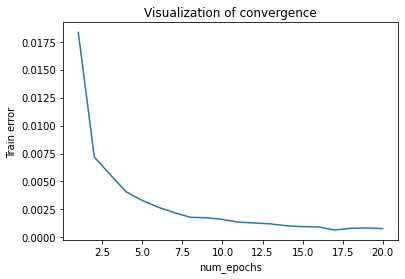

In [70]:
#new model
model = ConvNet()

#RMSprop optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_error_conv = train_conv(num_epochs, batch_size, criterion, optimizer, model, train_set)
accuracy_per_opti.append(float(accuracy_conv(val_set, model)))

In [71]:
accuracy_per_opti

[97.2889233152595, 98.83810999225406, 98.29589465530596]

Text(0.5, 1.0, 'Accuracy per optimizers')

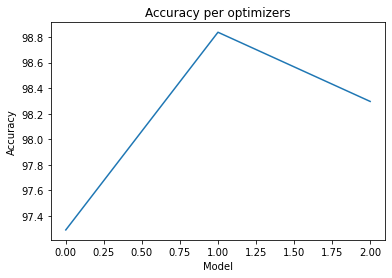

In [72]:
#plot loss

plt.plot(accuracy_per_opti)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy per optimizers")

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [73]:
# define a function for training
def train_conv_crossentropy(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images)

            #reshape the inputs from [N, img_shape, img_shape] to [N, C, img_shape, img_shape] mandatory for convolution 
            
            # One-hot encoding or labels so as to calculate MSE error:
            # labels_one_hot = torch.FloatTensor(batch_size, 10)
            # labels_one_hot.zero_()
            # labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            # loss = criterion(y_pre, labels_one_hot)
            loss = criterion(y_pre, labels)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))

    plt.plot(range(1, num_epochs+1), train_error)
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")
    return train_error

Epoch [1/20], Loss: 2.1125
Epoch [2/20], Loss: 1.7092
Epoch [3/20], Loss: 1.6519
Epoch [4/20], Loss: 1.6380
Epoch [5/20], Loss: 1.6337
Epoch [6/20], Loss: 1.6305
Epoch [7/20], Loss: 1.6276
Epoch [8/20], Loss: 1.6255
Epoch [9/20], Loss: 1.6233
Epoch [10/20], Loss: 1.6232
Epoch [11/20], Loss: 1.5759
Epoch [12/20], Loss: 1.5604
Epoch [13/20], Loss: 1.5552
Epoch [14/20], Loss: 1.5518
Epoch [15/20], Loss: 1.5527
Epoch [16/20], Loss: 1.5499
Epoch [17/20], Loss: 1.5498
Epoch [18/20], Loss: 1.5474
Epoch [19/20], Loss: 1.5465
Epoch [20/20], Loss: 1.5457


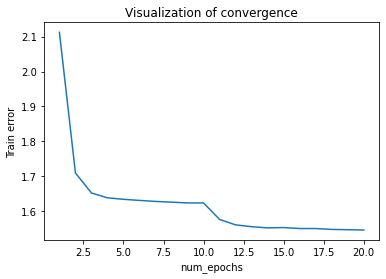

In [74]:
# Create the model: 
model = ConvNet()

# Choose the hyperparameters for training: 
num_epochs = 20
batch_size = 8

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error_conv = train_conv_crossentropy(num_epochs, batch_size, criterion, optimizer, model, train_set)

In [75]:
#accuracy with cross entropy
accuracy_conv(val_set, model)

Accuracy of the model : 91.09 %


'91.09217660728117'

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [76]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [77]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

Epoch [1/30], Loss: 0.0240
Epoch [2/30], Loss: 0.0067
Epoch [3/30], Loss: 0.0045
Epoch [4/30], Loss: 0.0038
Epoch [5/30], Loss: 0.0030
Epoch [6/30], Loss: 0.0023
Epoch [7/30], Loss: 0.0017
Epoch [8/30], Loss: 0.0020
Epoch [9/30], Loss: 0.0014
Epoch [10/30], Loss: 0.0012
Epoch [11/30], Loss: 0.0015
Epoch [12/30], Loss: 0.0011
Epoch [13/30], Loss: 0.0009
Epoch [14/30], Loss: 0.0008
Epoch [15/30], Loss: 0.0007
Epoch [16/30], Loss: 0.0010
Epoch [17/30], Loss: 0.0007
Epoch [18/30], Loss: 0.0005
Epoch [19/30], Loss: 0.0008
Epoch [20/30], Loss: 0.0007
Epoch [21/30], Loss: 0.0006
Epoch [22/30], Loss: 0.0012
Epoch [23/30], Loss: 0.0005
Epoch [24/30], Loss: 0.0004
Epoch [25/30], Loss: 0.0004
Epoch [26/30], Loss: 0.0008
Epoch [27/30], Loss: 0.0007
Epoch [28/30], Loss: 0.0005
Epoch [29/30], Loss: 0.0005
Epoch [30/30], Loss: 0.0004
Accuracy of the model : 97.68 %


'97.67621998450814'

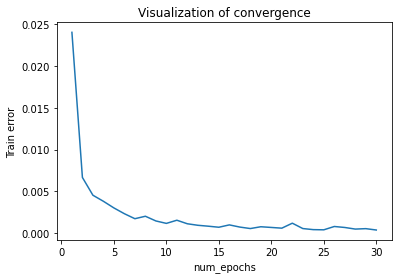

In [78]:
#use the best parameters we found:

model = ConvNet()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.MSELoss()

num_epochs = 30
batch_size = 8


train_error_conv = train_conv(num_epochs, batch_size, criterion, optimizer, model, train_set)
accuracy_conv(val_set, model)

In [79]:
accuracy_conv(test_set, model)

Accuracy of the model : 95.52 %


'95.51569506726457'